In [48]:
import os
import requests
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from goppy import OnlineGP
from goppy.kernel import SquaredExponentialKernel


In [ ]:
def download_and_extract(data_dir='data'):
    os.makedirs(data_dir, exist_ok=True)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
    zip_path = os.path.join(data_dir, "LD2011_2014.txt.zip")
    txt_path = os.path.join(data_dir, "LD2011_2014.txt")
    if not os.path.exists(txt_path):
        r = requests.get(url)
        with open(zip_path,"wb") as f: f.write(r.content)
        with zipfile.ZipFile(zip_path,"r") as z: z.extractall(data_dir)
    return txt_path

def load_daily_aggregate(txt_path, data_dir='data'):
    processed_path = os.path.join(data_dir, "daily_aggregate.pkl")
    if os.path.exists(processed_path):
        return pd.read_pickle(processed_path)
    df = pd.read_csv(txt_path, sep=';', index_col=0, parse_dates=True)
    df = df.replace(',', '.', regex=True).astype(float)
    df['total'] = df.sum(axis=1)
    daily = df[['total']].resample('D').sum()
    daily.to_pickle(processed_path)
    return daily

txt = download_and_extract()
daily = load_daily_aggregate(txt).loc['2011-11-21':'2014-12-31']
daily['t_day'] = (daily.index - daily.index[0]).days

kernel = SquaredExponentialKernel([4.95], variance=1.0)
gp = OnlineGP(kernel=kernel, noise_var=0.1)

train = daily.loc[:]
test  = daily.loc['2014-01-01':]

X_train = train['t_day'].values.reshape(-1, 1)
y_train = train['total'].values.reshape(-1, 1)
X_test  = test ['t_day'].values.reshape(-1, 1)
y_test  = test ['total'].values.reshape(-1, 1)

y_mean, y_std = y_train.mean(), y_train.std()
ytr_n = (y_train - y_mean) / y_std
yte_n = (y_test  - y_mean) / y_std


Time to run: 10.26158595085144


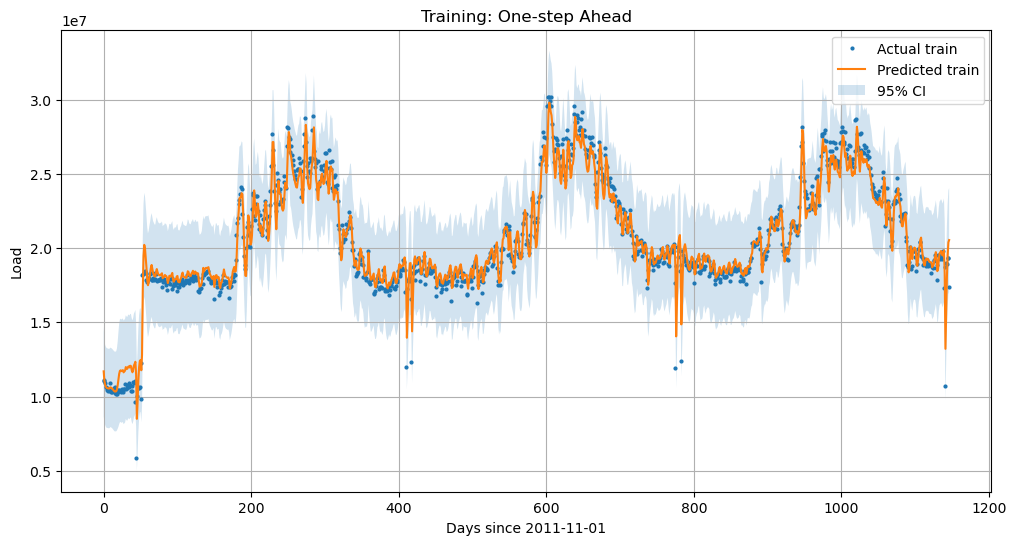

In [50]:
import time

t1 = time.time()
X0, y0 = X_train[:20], ytr_n[:20].reshape(-1,1)
gp.fit(X0, y0)

preds_tr, vars_tr = [], []
for x, y in zip(X_train, ytr_n):
    x_row = x.reshape(1, -1)

    out = gp.predict(x_row, what=('mean','mse'))
    mean, mse = out['mean'][0,0], out['mse'][0]
    preds_tr.append(mean)
    vars_tr.append(mse)

    gp.add(x_row, np.array([[y]]))

print("Time to run:", time.time() - t1)

p_tr = np.array(preds_tr)*y_std + y_mean
s_tr = np.sqrt(np.array(vars_tr))*y_std
# p_te = np.array(preds_te)*y_std + y_mean
# s_te = np.sqrt(np.array(vars_te))*y_std

plt.figure(figsize=(12,6))
plt.plot(train['t_day'], y_train, 'o', markersize=2, label="Actual train")
plt.plot(train['t_day'], p_tr, '-', label="Predicted train")
plt.fill_between(train['t_day'],
                 p_tr - 1.96*s_tr,
                 p_tr + 1.96*s_tr,
                 alpha=0.2, label="95% CI")
plt.title("Training: One-step Ahead")
plt.xlabel("Days since 2011-11-01"); plt.ylabel("Load")
plt.legend(); plt.grid(True)

# plt.figure(figsize=(12,6))
# plt.plot(test['t_day'], y_test, 'o', markersize=2, label="Actual test")
# plt.plot(test['t_day'], p_te, '-', label="Predicted test")
# plt.fill_between(test['t_day'],
#                  p_te - 1.96*s_te,
#                  p_te + 1.96*s_te,
#                  alpha=0.2, label="95% CI")
# plt.title("Testing: One-step Ahead")
# plt.xlabel("Days since 2011-11-01"); plt.ylabel("Load")
# plt.legend(); plt.grid(True)

plt.show()
